In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [4]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import processing

import photutils
from photutils.centroids import centroid_com


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [9]:
data_dir = "/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test/"
root = 'galaxies_blended_20191024'

In [10]:
images = np.load(data_dir+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
shifts = np.load(data_dir+'galaxies_blended_20191024_0_shifts.npy', mmap_mode = 'c')

In [13]:
%run -i ../../scripts/Images_generation/images_generator.py
%run -i ../../scripts/Images_generation/cosmos_params.py

1


In [8]:
def peak_detection(denormed_img, band, shifts, img_size, npeaks, nb_blended_gal, training_or_test, dist_cut):
    gal = denormed_img
    df_temp = photutils.find_peaks(gal, threshold=5*np.sqrt(sky_level_pixel[band]), npeaks=npeaks, centroid_func=centroid_com)
    if df_temp is not None:
        df_temp['x_peak'] = (df_temp['x_centroid']-((img_size/2.)-0.5))*pixel_scale[band]
        df_temp['y_peak'] = (df_temp['y_centroid']-((img_size/2.)-0.5))*pixel_scale[band]
        df_temp.sort('peak_value', reverse=True)
        # Distances of true centers to brightest peak
        qq = [np.sqrt(float((shifts[j,0]-df_temp['x_peak'][0])**2+ (shifts[j,1]-df_temp['y_peak'][0])**2)) for j in range(nb_blended_gal)]
        idx_closest = np.argmin(qq)
        if nb_blended_gal>1:
            # Distance from peak galaxy to others
            qq_prime = [np.sqrt(float((shifts[idx_closest,0]-shifts[j,0])**2+ (shifts[idx_closest,1]-shifts[j,1])**2)) if j!=idx_closest else np.inf for j in range(nb_blended_gal)]
            idx_closest_to_peak_galaxy = np.argmin(qq_prime)
            if training_or_test != 'test':
                if not np.all(np.array(qq_prime) > dist_cut):
                    print('TRAINING CUT: closest is not central and others are too close')
                    return False
        else:
            idx_closest_to_peak_galaxy = np.nan
        return idx_closest, idx_closest_to_peak_galaxy, df_temp[0]['x_centroid'], df_temp[0]['y_centroid'], df_temp[0]['x_peak'], df_temp[0]['y_peak'], len(df_temp)
    else:
        return False

In [ ]:
blends_noisy = images[:,1]
max_stamp_size = 64

In [ ]:
band = 6

peak_detection_output = peak_detection(blends_noisy, band, shifts, max_stamp_size*2, 4,nb_blended_gal, training_or_test, dist_cut=0.65/2.)
if not peak_detection_output:
    print('No peak detected')
    raise RuntimeError
else:
    idx_closest_to_peak, idx_closest_to_peak_galaxy, center_pix_x, center_pix_y, center_arc_x, center_arc_y, n_peak = peak_detection_output

# Modify galaxies and shift accordingly
galaxies = [gal.shift(-center_arc_x, -center_arc_y) for gal in galaxies]
shift[:nb_blended_gal] -= np.array([center_arc_x, center_arc_y])

In [37]:
e_beta.shape

(10000, 2, 2)

(0, 1)

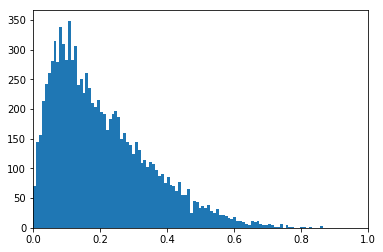

In [38]:
_ = plt.hist(e_beta[:,0,0], bins = 100)
plt.xlim(0,1)

(0, 1)

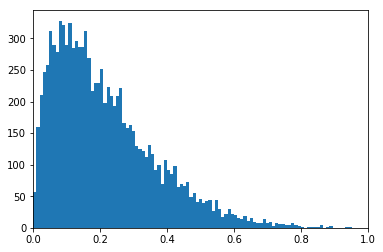

In [39]:
_ = plt.hist(e_beta[:,1,0], bins = 100)
plt.xlim(0,1)

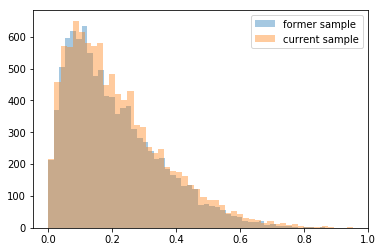

In [46]:
_ = plt.hist(e_beta[:,0,0], bins = 50, alpha = 0.4, label='former sample')
_ = plt.hist(e_beta[:,1,0], bins = 50, alpha = 0.4, label='current sample')

plt.legend()

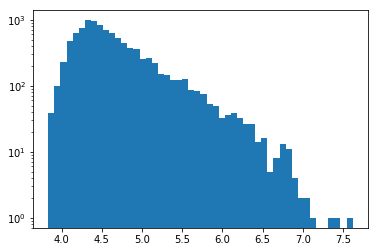

In [40]:
_ = plt.hist(np.log10(flux_in), bins = 50, log = True)

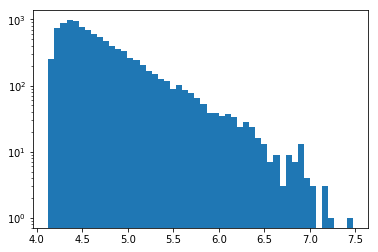

In [41]:
_ = plt.hist(np.log10(flux_out), bins = 50, log = True)

In [42]:
mag_former = -2.5*np.log10(flux_in)+38.4147
mag_now = -2.5*np.log10(flux_out)+38.4147

In [43]:
mag_former.shape

(10000,)

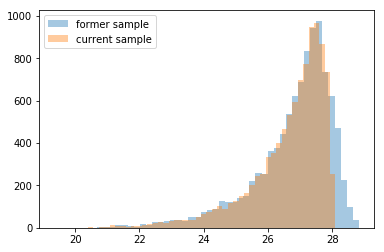

In [44]:
_ = plt.hist(mag_former, bins = 50, alpha = 0.4, label='former sample')
_ = plt.hist(mag_now, bins = 50, alpha = 0.4, label='current sample')

plt.legend()

In [45]:
np.max(mag_now)

28.10048569533257

In [54]:
input_noiseless = former[:,1]
output_vae = denorm(now[:,1], np.arange(10))

flux_in = []
flux_out = []
for j in range(10000):
    # Measurement of fluxes
    #mask = plot.createCircularMask(im_size,im_size,None,5)
    masked_img_in_simple = input_noiseless[j][r_band,:,:]
    #masked_img_in_simple[~mask] = 0  

    masked_img_out_simple = output_vae[j][r_band,:,:]
    #masked_img_out_simple[~mask] = 0

    # Calculate the luminosity by substracting the noise
    #flux_in[j,i] = np.sum(masked_img_in_simple)
    flux_in.append(np.sum(masked_img_in_simple))
    #flux_out[j,i] = np.sum(masked_img_out_simple)
    flux_out.append(np.sum(masked_img_out_simple))

    # Save scale radius and SNR
    #scale_radius.append(input_vae[2][i])
    #SNR.append(input_vae[3][i])

    #except :
    #    print('error for galaxy '+str(j*100))
    #    pass
    #continue

    #indices.append(input_vae[3])

flux_in_noisy = np.array(flux_in)#np.concatenate(flux_in)
flux_out_noisy = np.array(flux_out)#np.concatenate(flux_out)

In [55]:
np.max(flux_out_noisy)

29674813.31249913

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


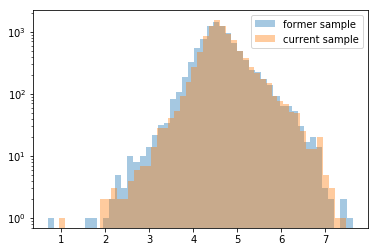

In [57]:
_ = plt.hist(np.log10(flux_in_noisy), bins = 50, log = True, alpha = 0.4, label='former sample')
_ = plt.hist(np.log10(flux_out_noisy), bins = 50, log = True, alpha = 0.4, label='current sample')

plt.legend()

In [80]:
former = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/galaxies_COSMOS_4_v5_test.npy', mmap_mode = 'c')
now = np.load('/sps/lsst/users/barcelin/data/single_galaxies/training/galaxies_isolated_20191022_2_images.npy', mmap_mode = 'c')

In [81]:
input_noiseless = norm(former[:,1], np.arange(10))
output_vae = now[:,1]# denorm(, np.arange(10))

flux_in = []
flux_out = []
for j in range(10000):
    # Measurement of fluxes
    masked_img_in_simple = input_noiseless[j][r_band,:,:]

    masked_img_out_simple = output_vae[j][r_band,:,:]
    #masked_img_out_simple[~mask] = 0

    # Calculate the luminosity by substracting the noise
    #flux_in[j,i] = np.sum(masked_img_in_simple)
    flux_in.append(np.ravel(masked_img_in_simple))
    #flux_out[j,i] = np.sum(masked_img_out_simple)
    flux_out.append(np.ravel(masked_img_out_simple))


flux_in_noisy = np.concatenate(np.array(flux_in))
flux_out_noisy = np.concatenate(np.array(flux_out))

In [82]:
np.min(flux_in_noisy), np.max(flux_in_noisy)

(-0.5597217903257479, 0.9999921669594374)

In [83]:
np.min(flux_out_noisy), np.max(flux_out_noisy)

(-0.5484843788683003, 0.9999948799538035)

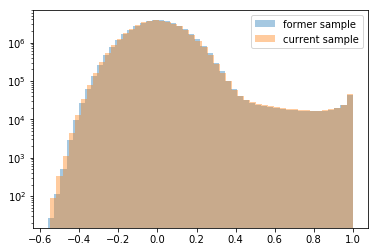

In [84]:
_ = plt.hist(flux_in_noisy, bins = 50, log = True, alpha = 0.4, label='former sample')
_ = plt.hist(flux_out_noisy, bins = 50, log = True, alpha = 0.4, label='current sample')

#plt.xlim(0, np.max(np.log10(flux_in_noisy)))
plt.legend()
#plt.xscale('log')